In [ ]:
#link google drive

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

#install any necessary packages to the colab env
!pip install wfdb
!pip install neurokit2
!pip install py-ecg-detectors
!pip install bigO

#change path in google colab to import functions from the toolbox
os.getcwd()
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/Orphanidou "
os.chdir(new_direct)
from orphanidou import assess_qual

#change path in google colab to import functions from the toolbox
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/Automated_ecg_assessment_og'
os.chdir(path)
from toolbox.AlgorithmsV5_k_model import processing

#change path in google colab to import functions from the toolbox
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/ECGAssess_og'
os.chdir(path)
from Code.AlgorithmsV5 import processing1

#change path in google colab to import functions from the toolbox
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/framework_for_synthetic_biosignals"
os.chdir(new_direct)

import ecg_generator as eg
import noise_generator as ng
import beat_interval_generator as big
import tensorflow as tf

import sys
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project'
os.chdir(path)

from functions import plotting_df
from functions import first_below_05

#other tools to use
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from ecgdetectors import Detectors
import scipy.stats
import neurokit2 as nk
import time
import tensorflow as tf
import pandas as pd


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=74c0a76e8def83fc31c27fd026f2c5629cfe76d354666d6bf2abd0d8e17a395d
  Stored in directory: /root/.cache/pip/wheels/13/39/c2/d113611d276bf55252ed5a640e98596d7dcc96535afbf254d5
Successfully built gatspy


In [ ]:
#load in the pre-set beat intervals control HR
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_work/framework_for_synthetic_biosignals/beats_array.npy'
beats2 = np.load(path)

In [ ]:
#Changing the point value with a point frequency of 0.5Hz:
#set the increment in point value
increment = 5

# Create a dataframe with the following columns: noise type, signal, SQA1, SQA2, SQA3
df_PV = pd.DataFrame(columns=['Noise Type', 'SQA1', 'SQA2', 'SQA3', 'SQA4'])


# Generate and plot ECG signals with increasing heart rates
for i in range(0, 100):

    # Calculate heart rate for the current signal
    pv = 0 + i * increment  # Incremental increase from 20 to 200 BPM
    print(pv)

    #create preset zero's array for efficiency
    SQA_O = np.zeros(100)
    SQA_Z = np.zeros(100)
    SQA_E = np.zeros(100)
    SQA_A = np.zeros(100)


    #add heart rate to the dataframe
    df_PV.at[i, 'Noise Type'] = str(pv)

    #create 100 variations with the same set variable
    for j in range(100):

      # Create ECG signal with the specified PV
      ecg = eg.ECGGenerator()
      ecg.beat_interval_generator.beat_intervals = beats2
      ecg.noise_generator.noise_type.point_bool = True
      ecg.noise_generator.noise_type.point_freq = 0.5
      ecg.noise_generator.noise_type.point_value = pv
      signal, peaks, labels, beats = ecg.generate()
      signal = signal[0:2000]

      #plt.plot(signal)
      #plt.show()

      #run the signal through Orphanidou SQI
      quality_o = assess_qual(signal, fs = 200, thresh = 0.66)

      #run the signal through the Zhao & Zhang SQI with a break if failure
      try:
        quality_z = nk.ecg_quality(signal, sampling_rate=200, method="zhao2018")
      except Exception as e:
        print(f"An error occurred: {e}")
        quality_z = 'Unacceptable'

      #resample the signal (to 500Hz) and reshape into an array with the first row as the index for values in ECG (for final 2 SQI's as this is done in their respective packages)
      resampled_signal = nk.signal_resample(signal, sampling_rate=200, desired_sampling_rate=500, method="numpy")
      reshaped_array = np.vstack((np.arange(5000), resampled_signal))

      #run the processed signal through the ECGAssess (processsing1 func)
      quality_e = processing1(reshaped_array, total_leads=1, temp_freq=500)

      #run the prcoessed signal through the Elegendi SQI (processing func)
      qaulity_a = processing(reshaped_array, num_leads=1, temp_freq = 500, SNR_threshold = 0.5, signal_freq_band = [2, 40], window_length = 100, heart_rate_limits = [25, 300], max_loss_passband = 0.1,
               min_loss_stopband=20, sampling_frequency=500, path_model='/content/drive/MyDrive/Colab_Notebooks/CiC_work/Automated_ecg_assessment_og/cnn_lstm/', name_model = 'saved_model')

      #add the results of the orphanidou & Zhao Zhang SQI to the saved arrays
      SQA_O[j] = 0 if quality_o == 0 else 1
      SQA_Z[j] = 0 if quality_z == 'Unacceptable' else 1

      #for ECGAssess and Elgendi SQI's then need to extract outputs from the SQI ('✖' = fail)
      ecg_result = 0 if quality_e[3][0] == '✖' else 1
      SQA_E[j] = 0 if ecg_result == 0 else 1

      auto_result = 0 if qaulity_a[4][0] == '✖' else 1
      SQA_A[j] = 0 if auto_result == 0 else 1

      #print(SQA_O)
      #print(SQA_Z)
      #print(SQA_E)
      #print(SQA_A)

    #calculate the mean chance of pass value from each iteration of 50 signals and add to dataframe
    SQA_O_prob = np.mean(SQA_O)
    print(SQA_O_prob)
    df_PV.at[i, 'SQA1'] = SQA_O_prob

    SQA_Z_prob = np.mean(SQA_Z)
    print(SQA_Z_prob)
    df_PV.at[i, 'SQA2'] = SQA_Z_prob

    SQA_E_prob = np.mean(SQA_E)
    print(SQA_E_prob)
    df_PV.at[i, 'SQA3'] = SQA_E_prob

    SQA_A_prob = np.mean(SQA_A)
    print(SQA_A_prob)
    df_PV.at[i, 'SQA4'] = SQA_A_prob

path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)
df_PV.to_csv('PV_final')


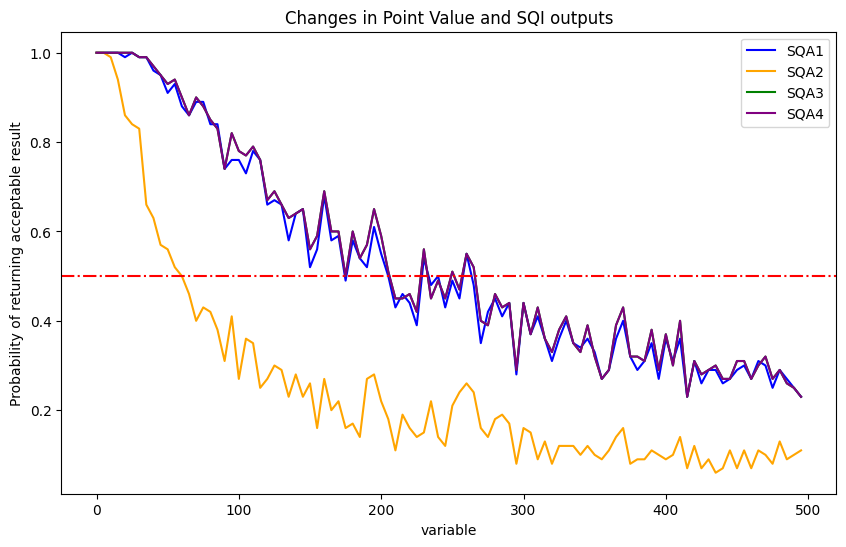

In [ ]:
#if cells above already run can then import the dataframe from saved_data file
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)

dfPV = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data/PV_final')
plotting_df(dfPV, 'Changes in Point Value and SQI outputs')

In [ ]:
#use the function first_below_05 to find the first value from each SQI that returned a value below 0.5

SQI1 = first_below_05(dfPV, 'SQA1')
print(SQI1)
SQI2 = first_below_05(dfPV, 'SQA2')
print(SQI2)
SQI3 = first_below_05(dfPV, 'SQA3')
print(SQI3)
SQI4 = first_below_05(dfPV, 'SQA4')
print(SQI4)

175
65
210
210


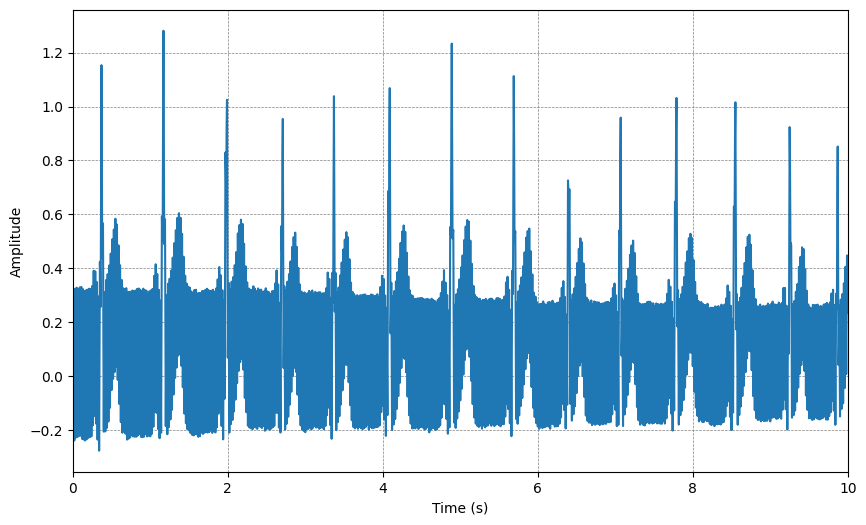

In [ ]:
#produce the graphs for at the maximum HR at at which point the SQI's still return a pass value:
increment = 5
ecg = eg.ECGGenerator()
ecg.beat_interval_generator.beat_intervals = beats2
ecg.noise_generator.noise_type.point_bool = True
ecg.noise_generator.noise_type.point_freq = 0.5
ecg.noise_generator.noise_type.point_value = SQI1 - increment
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate


plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)

plt.xlim(0, 10)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 11, 2))

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()